In [1]:
%cd /home/rguillaume/developpements/Publications/2024_Guillaume-Castel_PatternEffect_on_TCR

/home/rguillaume/developpements/Publications/2024_Guillaume-Castel_PatternEffect_on_TCR


In [2]:
import lenapy
import xarray as xr 
import xesmf as xe 
from xmip.preprocessing import combined_preprocessing, rename_cmip6
from xmip.drift_removal import unify_time
import pandas as pd 
import numpy as np
import xesmf as xe
import glob
import os
import warnings
from xarrayutils import xr_linregress
from tqdm.notebook import tqdm
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit
import intake
import matplotlib.pyplot as plt 
plt.style.use('robin')
plt.rcParams['font.family'] = 'sans'

In [3]:
from dask.distributed import Client
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 48,Total memory: 96.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45027,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 96.00 GiB
Comm: tcp://127.0.0.1:45309,Total threads: 6
Dashboard: http://127.0.0.1:35873/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:33261,


In [4]:
import cftime 

In [5]:
def preprocess(ds):
    ds = rename_cmip6(ds.assign_coords(member_id=ds.attrs['variant_label']))
    branch_time_int = ds.attrs['branch_time_in_parent']
    parents_time_units = ds.attrs['parent_time_units']
    branch_time = cftime.num2date(branch_time_int, calendar=ds.time.values[0].calendar, units = parents_time_units)
    print(branch_time)
    return ds.assign_coords(branch_time=branch_time)
ds_multi = xr.open_mfdataset(glob.glob('/bdd/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/*/Omon/tos/gn/latest/*'), combine='nested', concat_dim='member_id', preprocess=preprocess, chunks=dict(time=120)).resample(time='YS').mean()
ds_multi = ds_multi.where(ds_multi.member_id.str.count('i1p1f1')>0, drop=True)
ds_multi['time'] = np.arange(151)
grid = rename_cmip6(xr.open_mfdataset(glob.glob('/bdd/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/*/Ofx/areacello/gn/latest/*')[0]))
areacello= grid.areacello.fillna(0)

/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(


5650-01-01 00:00:00
5251-01-01 00:00:00
5201-01-01 00:00:00
5301-01-01 00:00:00
5600-01-01 00:00:00
5550-01-01 00:00:00


In [6]:
control = rename_cmip6(xr.open_mfdataset(glob.glob('/bdd/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p1f1/Omon/tos/gn/latest/*'), chunks = dict(time=60)).resample(time='YS').mean())
controls = xr.concat([control.sel(time=slice(ds_multi.branch_time[k], None)).isel(time=slice(0,150)).assign_coords(member_id=ds_multi.member_id[k], time=range(150)) for k in range(3)], dim='member_id').tos
controls_mean = controls.weighted(areacello).mean(['x','y']).load()
controls_local = controls.isel(time=range(10)).mean('time').load()

tos_global = ds_multi.tos.weighted(areacello).mean(['x','y']).load()

In [8]:
ds_tos = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/tos_data.nc')


In [12]:
dtos_local = ds_multi.tos - controls_local
dtos_global = tos_global - xr.polyval(tos_global.time, controls_mean.polyfit('time', deg=1).polyfit_coefficients)
pattern = (dtos_local-dtos_global)#.rename(longitude='lon',latitude='lat')
regridded_pattern = xe.Regridder(pattern, ds_tos.tos_control_grid, 'bilinear', periodic=True)(pattern)#.assign_coords(GF_source=model.split('.')[0])

In [13]:
gf_directory = '/projets/EMC2/data/Models/GFMIP/preliminary_spatial_feedbacks-main/data/'
list_gf_models = os.listdir(gf_directory)


list_gf_regridded = []
for model in tqdm(list_gf_models):
    with xr.open_dataset(f"{gf_directory}/{model}") as ds_raw:
        if "spatial_feedbacks_from_both" in ds_raw.variables:
            data = ds_raw.spatial_feedbacks_from_both
        else:
            data = ds_raw.spatial_feedbacks_from_warming
    regridded_ds = xe.Regridder(data, ds_tos.tos_control_grid, 'conservative_normed', periodic=True)(data).assign_coords(GF_source=model.split('.')[0])
    list_gf_regridded.append(regridded_ds)
greens_functions = xr.concat(list_gf_regridded, dim='GF_source' )
greens_functions = greens_functions.where(greens_functions!=0)
greens_functions = greens_functions.where(greens_functions.count('GF_source')==greens_functions.count('GF_source').max())
greens_functions.attrs['units'] = 'W/m²'
greens_functions.attrs['long_name'] = "Green's functions coefficients"

weights = xr.ones_like(greens_functions)*np.cos(np.deg2rad(greens_functions.lat))
weights = weights/weights.sum(['lon','lat'])
greens_functions = greens_functions*weights

all_gf = greens_functions.where(greens_functions!=0)
# all_gf = all_gf.where(all_gf.count('GF_source')==all_gf.count('GF_source').max())
mean_gf = all_gf.mean('GF_source')

  0%|          | 0/6 [00:00<?, ?it/s]

/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [14]:
dRp_gf = (all_gf*regridded_pattern).sum(['lon','lat'])
dRp_gf.rename('dRp').to_netcdf("/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/review/dRp_1pct_CanESM5_multi_member.nc")

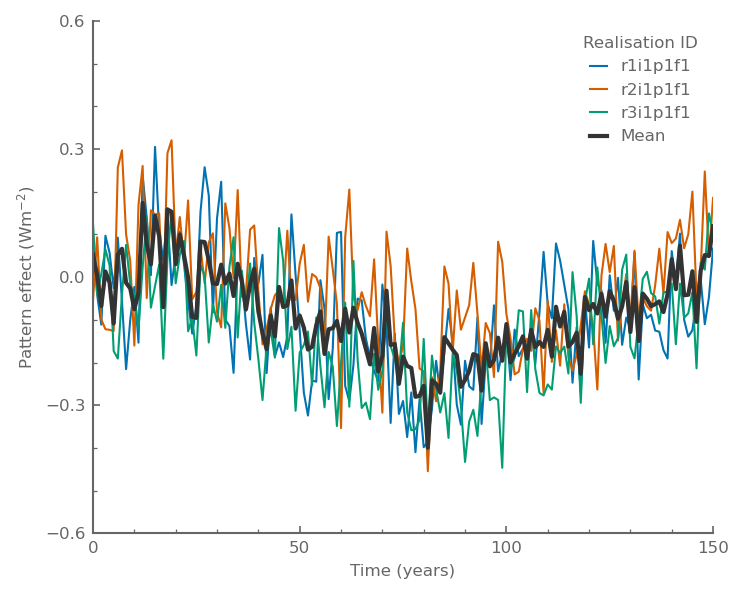

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))

dRp_gf.mean('GF_source').sel(member_id='r1i1p1f1').plot(label='r1i1p1f1')
dRp_gf.mean('GF_source').sel(member_id='r2i1p1f1').plot(label='r2i1p1f1', color='C3')
dRp_gf.mean('GF_source').sel(member_id='r3i1p1f1').plot(label='r3i1p1f1', color='C2')
dRp_gf.mean(['GF_source','member_id']).plot(color='.2', lw=2, label='Mean')

ax.legend(title='Realisation ID')
ax.set_ylim(-.6,.6)
ax.set_xlim(0,150)
ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))

ax.yaxis.set_major_locator(mticker.MultipleLocator(.3))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(.1))

ax.set_ylabel('Pattern effect ($Wm^{-2}$)')
ax.set_xlabel('Time (years)')
plt.tight_layout()
plt.savefig('plots/CanESM5_multi_member.pdf')
plt.savefig('plots/CanESM5_multi_member.svg')